## Due to unalignment of persian font this documantation had been written in English

This notebook demonstrates how train a DCGAN on the Cifar10 dataset.


## Import TensorFlow and other libraries

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from matplotlib import pyplot

In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Tue Aug  4 07:54:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+

## Load the Cifar10 dataset
Each Cifar10 image is originally a vector of 32*32 integers with 3 channels, each of which is between 0-255 and represents the intensity of a pixel. then preprocces it and scale to [-1, 1]

In [ ]:
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

## select real samples for generator


In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

## Constructing Generator Architecture 
Network architecture includes a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). and for output a Convolution Layer

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

generate points in latent space as input for the generator

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

## Constructing Discriminator Architecture 
Network architecture includes four convolution layer with Dropout and Leaky Relu activation followed by 1 dimentional fully-connected layer to find fake ot realness</br>
Adam has been used for optimizer with learning rate of 0.002

In [ ]:
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 

## Define DCGAN Model by adding generator and discriminator

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

## use the generator to generate n fake examples, with class labels

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

## plot and save created images


In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	pyplot.savefig("images/%d.png" % epoch)
	pyplot.close()

## Evaluate performance by finding Accuracy of the model

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

## Train Gan model

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)

  dis1_loss_history = []
  dis2_loss_history = []
  gen_loss_history = []
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
        (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
      dis1_loss_history.append(d_loss1)
      dis2_loss_history.append(d_loss2)
      gen_loss_history.append(g_loss)
    # evaluate the model performance, sometimes
    if (i+1) % 10 == 1:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
  return dis1_loss_history, dis2_loss_history, gen_loss_history

Train Network DCGAN for 30 Epoch and noise dim of 100

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
dis1_loss_history, dis2_loss_history, gen_loss_history = train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>188, 73/390, d1=0.585, d2=0.542 g=1.338
>188, 74/390, d1=0.584, d2=0.569 g=1.305
>188, 75/390, d1=0.600, d2=0.489 g=1.288
>188, 76/390, d1=0.502, d2=0.527 g=1.288
>188, 77/390, d1=0.544, d2=0.472 g=1.426
>188, 78/390, d1=0.611, d2=0.462 g=1.143
>188, 79/390, d1=0.487, d2=0.560 g=1.277
>188, 80/390, d1=0.517, d2=0.449 g=1.278
>188, 81/390, d1=0.556, d2=0.488 g=1.197
>188, 82/390, d1=0.482, d2=0.582 g=1.336
>188, 83/390, d1=0.449, d2=0.465 g=1.411
>188, 84/390, d1=0.506, d2=0.472 g=1.278
>188, 85/390, d1=0.514, d2=0.430 g=1.347
>188, 86/390, d1=0.501, d2=0.467 g=1.371
>188, 87/390, d1=0.469, d2=0.479 g=1.270
>188, 88/390, d1=0.552, d2=0.558 g=1.320
>188, 89/390, d1=0.511, d2=0.493 g=1.321
>188, 90/390, d1=0.514, d2=0.477 g=1.352
>188, 91/390, d1=0.654, d2=0.481 g=1.313
>188, 92/390, d1=0.563, d2=0.563 g=1.336
>188, 93/390, d1=0.607, d2=0.550 g=1.279
>188, 94/390, d1=0.542, d2=0.441 g=1.349
>188, 95/390, d1=0.568, d2=0.547 g=1.269
>188, 

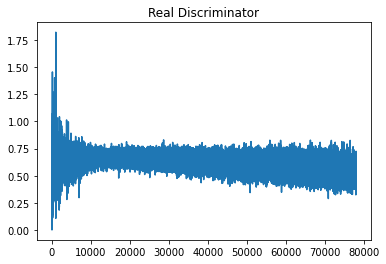

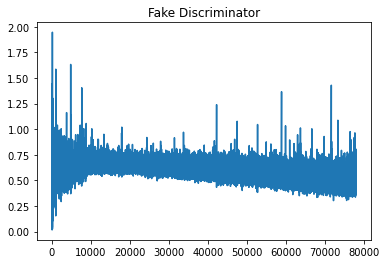

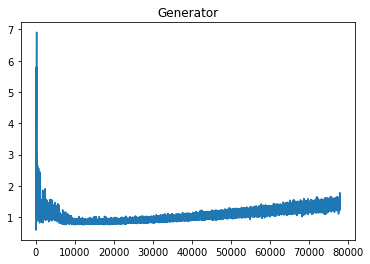

In [ ]:
pyplot.plot(dis1_loss_history)
pyplot.title('Real Discriminator')
pyplot.show()
pyplot.plot(dis2_loss_history)
pyplot.title('Fake Discriminator')
pyplot.show()
pyplot.plot(gen_loss_history)
pyplot.title('Generator')
pyplot.show()

In [ ]:
from google.colab import files
files.download('./images')

FileNotFoundError: ignored

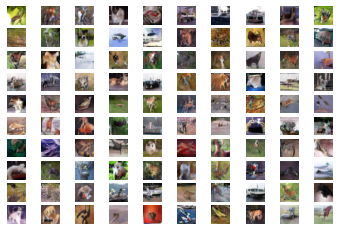

In [ ]:

x_fake, y_fake = generate_fake_samples(g_model, latent_dim, 150)
x_fake = (x_fake + 1) / 2.0
# plot images
n = 10
for i in range(n * n):
  # define subplot
  pyplot.subplot(n, n, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(x_fake[i])
# save plot to file
pyplot.show()
pyplot.close()